# Decoding and Verifying the Domestic NHS COVID Pass
_Rich Wareham (rich.nhs-pass@richwareham.com)_

In England, the NHS are allowing people to prove their vaccination status, natural immunity or a recent negative COVID test by means of a [NHS COVID Pass](https://www.nhs.uk/conditions/coronavirus-covid-19/covid-pass/). The pass is intended to be verified via a [companion app](https://play.google.com/store/apps/details?id=uk.gov.dhsc.healthrecord).

There are two forms of COVID pass available: an _international_ pass compatible with the [EU Digital Green Certificate](https://ec.europa.eu/info/live-work-travel-eu/coronavirus-response/safe-covid-19-vaccines-europeans/eu-digital-covid-certificate_en) and a _domestic_ pass intended to be shown on entry to events, nightclubs, etc which opt to make use of it.

The international pass contains an individual's full vaccination record whereas the domestic pass contains only a name and an expiry date. If an individual can present a valid NHS COVID pass they are deemed to be sufficiently protected or tested.

This notebook provides an example of how to parse and validate the domestic pass along with some implementation notes.

## The existing app

[Source code](https://github.com/nhsx/covid-pass-verifier) for the existing app is available on GitHub and is [licensed](https://github.com/nhsx/covid-pass-verifier/blob/ef3b3faa34cb7b37fcb59903e1e09cd8eb1e9d0d/LICENSE) under an MIT-style license with Copyright asserted by Craig Shenton. Some of the work below is the result of reading the app's source code.

## Dependencies

We first need to install some dependencies:

In [1]:
!pip install qrcode[pil] ecdsa

## QR payload

The pass itself takes the form of a QR code which encodes an ASCII payload. An example of an expired pass is given below:

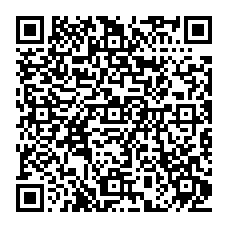

In [2]:
import qrcode

qr_payload = 'S2V5MVJF.MTIxMDcxOTA5NTZSSUNIQVJEIFdBUkVIQU0.IBAR-qC1Xhu1WIJPDb-wUipLC7-_HZSfIHC7rYhEJBDohiImNYVbHMt8vpLnkuVmKMoU1OrlCSYD1bpqxGRamA'
qrcode.make(qr_payload, box_size=4)

The QR code's payload is modelled after the structure of a [JSON Web Token](https://jwt.io/) and contains a _header_ and _payload_ and a _signature_ separated by full-stop (`.`) characters.

In [3]:
header, payload, signature = qr_payload.split('.')

## Verification key

In order to verify the signature, we need to obtain a public key. The [public keys](https://covid-status.service.nhsx.nhs.uk/pubkeys/keys.json) are available from a public HTTPS endpoint:

In [4]:
import urllib.request
import json

with urllib.request.urlopen('https://covid-status.service.nhsx.nhs.uk/pubkeys/keys.json') as f:
    keys = json.load(f) 

The keys are a JSON array of objects matching key ids to Base64 encoded public keys:

In [5]:
keys

[{'kid': 'S2V5MVJF',
  'publicKey': 'MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAEtWokvmqrJOv/0PO9Vy8lpb6SgWw+rao0qIXntO/Bf7ExryL3yyKRI73IqAh38Lk4joqHrZK8XLZV9PMclgmTVg=='},
 {'kid': 'S2V5MlJF',
  'publicKey': 'MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAEAauvVllnjXm0toiI2cUQfCTdZiDQ6kvtoo1bSnl8W3Rq7WyOeHWYKhBaQ4rEBceqNl5+v1ZLGj0WfnIhXh246Q=='},
 {'kid': 'S2V5M1JF',
  'publicKey': 'MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAE2ZpDNa1VV6g2PkmyKoL1INO0MtTqE5WT45i3QhY9FFMjbF9ieqnHV4R814wrN3f3vzkx0VN/YJZH4rI1GDlfqw=='},
 {'kid': 'S2V5NFJF',
  'publicKey': 'MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAE8g5iFLRT7NyRmKp7pcP8uEgoHFhfmcXOLLD4RUtX50/Rh4Cz7l/faAiODNMmCkcWLA1Z8WOZoNFQsdmeDjXuLQ=='},
 {'kid': 'S2V5NVJF',
  'publicKey': 'MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAEOFOUp1+SLuaM3NnV+OMZKZOoPg76T7D+vqRCasD0BrRZmlUH2gD+aVlpKvp+u7h8ywTR7T6Z6/iI2Qe6F5begg=='},
 {'kid': 'S2V5MVBSTw==',
  'publicKey': 'MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAEyfUqlGg4hfyPYgZJzl1KepkfTaX+F3592syCJ0ylVOHA4fE6vavLXE4cG+Whz/eqyW/rFuZ0HBHHEskmpCngOA=='},
 {'kid

To find the appropriate public key we need only match the `kid` field to the header of the QR code payload. The keys themselves are elliptic curve public keys.

In [6]:
import ecdsa
import base64

pub_key_enc = [k['publicKey'] for k in keys if k['kid'] == header][0]
pub_key = ecdsa.VerifyingKey.from_der(base64.b64decode(pub_key_enc))

print('Found public key:')
print(pub_key.to_pem().decode().strip())

Found public key:
-----BEGIN PUBLIC KEY-----
MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAEtWokvmqrJOv/0PO9Vy8lpb6SgWw+
rao0qIXntO/Bf7ExryL3yyKRI73IqAh38Lk4joqHrZK8XLZV9PMclgmTVg==
-----END PUBLIC KEY-----


## Verifying the signature

The signature is encoded using the [URL-safe Base64 encoding](https://datatracker.ietf.org/doc/html/rfc4648) unlike the public keys which are encoded with vanilla Base64. In addition the padding characters have been stripped. We can use a trick whereby the base64 decode ignores additional padding characters to decode the signature by simply appending the maximum number of padding characters:

In [7]:
import binascii

signature_bytes = base64.urlsafe_b64decode(signature + '===')
print(f'Signature: {binascii.hexlify(signature_bytes).decode()}')

Signature: 201011faa0b55e1bb558824f0dbfb0522a4b0bbfbf1d949f2070bbad88442410e886222635855b1ccb7cbe92e792e56628ca14d4eae5092603d5ba6ac4645a98


The verifier app does [something which seems strange at this point](https://github.com/nhsx/covid-pass-verifier/blob/ef3b3faa34cb7b37fcb59903e1e09cd8eb1e9d0d/NHSCovidPassVerifier/Services/Repositories/QRDecoderService.cs#L84). Instead of simply stripping the signature encoding from the QR code payload it instead re-forms the first part of the token and re-encodes it using [Encoding.Unicode](https://docs.microsoft.com/en-us/dotnet/api/system.text.encoding.unicode?view=net-5.0):

```
var tokenParts = qrCode.Split('.');
if (tokenParts.Length != 3)
{
    return false;
}
var header = tokenParts[0];
var payload = tokenParts[1];
var signature = tokenParts[2];
var byteData = Encoding.Unicode.GetBytes($"{header}.{payload}");

var sigBytes = Base64UrlEncoder.DecodeBytes(signature);
```

This re-encodes the QR Code as UTF-16, little endian with a Byte Order Mark (BOM). I'm not sure _why_ it does this; verifying the ASCII encoded representation would be similarly secure and in general one wants to try and do as little processing on a token pre-verification as is possible. My, unfounded, suspicion is that this encoding happened inadvertently in the code which generated the signatures and the re-encoding here is a workaround although that's only my gut feeling. Nonetheless, the message to be verified has to be so encoded:

In [8]:
message = f'{header}.{payload}'.encode('utf_16_le')
print(f'Message: {message}')

Message: b'S\x002\x00V\x005\x00M\x00V\x00J\x00F\x00.\x00M\x00T\x00I\x00x\x00M\x00D\x00c\x00x\x00O\x00T\x00A\x005\x00N\x00T\x00Z\x00S\x00S\x00U\x00N\x00I\x00Q\x00V\x00J\x00E\x00I\x00F\x00d\x00B\x00U\x00k\x00V\x00I\x00Q\x00U\x000\x00'


The public key can then be used to verify the re-encoded payload using [ECDSA](https://en.wikipedia.org/wiki/Elliptic_Curve_Digital_Signature_Algorithm) and [SHA256](https://en.wikipedia.org/wiki/SHA-2):

In [9]:
import hashlib

# This will throw a BadSignature exception if the signature is invalid.
if pub_key.verify(signature_bytes, message, hashlib.sha256):
    print('Signature verified')

Signature verified


## Parsing the payload

The payload is also URL-safe Base64 encoded. We can decode it using the same padding trick:

In [10]:
payload_str = base64.urlsafe_b64decode(payload + '===').decode('ascii')
print(f'Payload: {payload_str}')

Payload: 12107190956RICHARD WAREHAM


The payload consists of a version identifier (in this case `1`) followed by the UTC expiry date and time in the [strftime format](https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior) `%y%m%d%H%M` and then the name of the individual. We firstly assert that the version number is `1`:

In [11]:
assert payload_str[:1] == '1'

The expiry date and name can be extracted and parsed from the payload:

In [12]:
import datetime

valid_datetime = datetime.datetime.strptime(payload_str[1:11], '%y%m%d%H%M')
name = payload_str[11:]

print(f'Valid until: {valid_datetime} (UTC)')
print(f'  Valid for: {name}')

Valid until: 2021-07-19 09:56:00 (UTC)
  Valid for: RICHARD WAREHAM


## Questions

There are some odd inconsistencies within the NHS COVID Pass:

### Why are public keys encoded with vanilla Base64 but the payload is encoded using the URL Safe variant?

It's likely that the public key endpoint was inspired by the [JSON Web Key format](https://datatracker.ietf.org/doc/html/rfc7517) which uses Base64 to encode public keys (well, [PEM](https://en.wikipedia.org/wiki/Privacy-Enhanced_Mail), but it's underpinned by Base64) whereas the token format was inspired by [JSON Web Tokens](https://jwt.io) which use the URL Safe variant. There's nothing inherently wrong with this, it's just a bit jarring.

### Why does signature verification require re-encoding of the payload and header?

This is more of a head-scratcher. The [JWS spec](https://www.rfc-editor.org/rfc/rfc7515.html) explicitly names UTF-8 as the encoding for the header and that the bytes of the payload must remain untouched. Indeed it would be common practice to leave the payload bytes alone until verification is complete. As indicated in the text I think this might be the result of an inadvertent encoding when the payload is signed.

## Comments

Overall the NHS COVID pass is "just complex enough" to solve its aims to provide a cryptographically signed assertion that a named individual has been issued a pass until a given expiry date. The verifier app appears to have had the domestic pass somewhat hacked in and the app itself is somewhat under-commented. That being said, it was probably put together in a hurry and the fact that it bolts existing crypto primitives for signature validation together rather than rolling their own is heartening.